In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from functions import (Calculate_CFD, plot_gaussian, get_gaussian_params,
                       calculate_gaussian_center, calculate_slope_y_intercept)

In [3]:
def move_to_reference2(reference, pulse_set, start=50, stop=80, max_delay=10, channel=0):

    if (stop - start) < max_delay:
        raise ValueError("Window size (stop-start) cannot be smaller than max_delay")

    # Extract the reference window
    reference_pulse = reference[start:stop]
    delays = []
    aligned_pulses = []

    for i in range(pulse_set.shape[0]):
        mse = []
        segments = []

        # Extract the current pulse channel and sliding window
        pulse = pulse_set[i, :, channel]
        for i in range(0, pulse_set.shape[1] - int(stop - start)):
            start_idx = i
            stop_idx = i + int(stop - start)

            # Ensure valid indices within bounds of the pulse array
            if start_idx < 0 or stop_idx > len(pulse):
                continue

            # Extract the sliding window segment
            segment = pulse[start_idx:stop_idx]
            mse.append(np.mean((reference_pulse - segment) ** 2))
            segments.append(segment)

        # Find the shift with the minimal MSE
        mse = np.array(mse)
        min_mse_index = np.argmin(mse)
        optimal_start = range(0, pulse_set.shape[1] - int(stop - start))[min_mse_index]
        optimal_shift = start - optimal_start  
        
        delays.append(optimal_shift)
        aligned_pulses.append(segments[min_mse_index])

    return np.array(delays), np.array(aligned_pulses)

In [4]:
# Load data 
dir = '/home/josea/DEEP_TIMING/DEEP_TIMING_VS/Na22_filtered_data/'

data_82 = np.load(os.path.join(dir, 'Na22_82_norm_ALBA_test.npz'))['data']
data_55 = np.load(os.path.join(dir, 'Na22_55_norm_ALBA_test.npz'))['data']
data_28 = np.load(os.path.join(dir, 'Na22_28_norm_ALBA_test.npz'))['data']

In [5]:
fraction = 0.064    # Fraction to attenuate pulse for CFD
shift = 6.8         # Delay for CFD 
threshold = 0.04    # Threshold for relative Leading Edge
nbins = 71
time_step = 0.2   # In ns
positions = np.array([0.2, 0.0, -0.2])

Text(0, 0.5, 'Error (ns)')

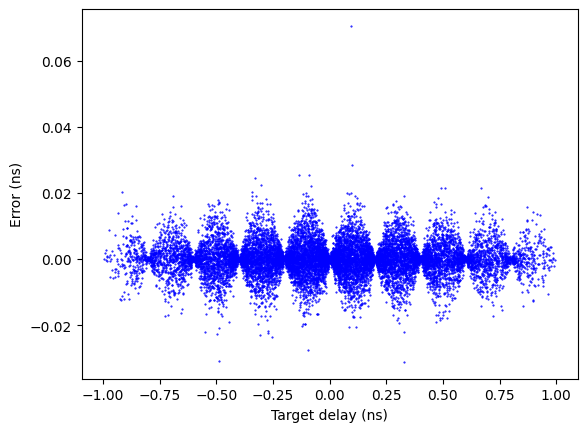

In [6]:
from functions import create_and_delay_pulse_pair
data = np.concatenate((data_28, data_55, data_82), axis = 0)
pulsesCFD, REF_CFD = create_and_delay_pulse_pair(data[:,:,0], time_step, delay_time = 1)

CFD0 = Calculate_CFD(pulsesCFD[:, :200, 0], fraction = fraction, shift = shift, time_step = time_step)
CFD1 = Calculate_CFD(pulsesCFD[:, :200, 1], fraction = fraction, shift = shift, time_step = time_step)

plt.plot(REF_CFD, CFD0 - CFD1 - REF_CFD, 'b.', markersize = 1)
plt.xlabel('Target delay (ns)')
plt.ylabel('Error (ns)')

# **CFD**

In [7]:
CTR = []
avg_bias = []
attenuation = np.array([0.01, 0.1, 0.2, 0.3])
delay = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9 ,10, 11, 12, 13])

for i in range(attenuation.shape[0]):
    CTR_attenuation = []
    avg_bias_attenuation = []
    for j in range(delay.shape[0]):
        timestamps_CFD_dec0_DATA_00 = Calculate_CFD(data_55[:, :200, 0], fraction = attenuation[i], shift = delay[j], time_step = time_step)
        timestamps_CFD_dec1_DATA_00 = Calculate_CFD(data_55[:, :200, 1], fraction = attenuation[i], shift = delay[j], time_step = time_step)

        timestamps_CFD_dec0_DATA_02 = Calculate_CFD(data_28[:, :200, 0], fraction = attenuation[i], shift = delay[j], time_step = time_step)
        timestamps_CFD_dec1_DATA_02 = Calculate_CFD(data_28[:, :200, 1], fraction = attenuation[i], shift = delay[j], time_step = time_step)

        timestamps_CFD_dec0_DATA_20 = Calculate_CFD(data_82[:, :200, 0], fraction = attenuation[i], shift = delay[j], time_step = time_step)
        timestamps_CFD_dec1_DATA_20 = Calculate_CFD(data_82[:, :200, 1], fraction = attenuation[i], shift = delay[j], time_step = time_step)

        TOF_CFD_V00 = timestamps_CFD_dec0_DATA_00 - timestamps_CFD_dec1_DATA_00
        TOF_CFD_V02 = timestamps_CFD_dec0_DATA_02 - timestamps_CFD_dec1_DATA_02
        TOF_CFD_V20 = timestamps_CFD_dec0_DATA_20 - timestamps_CFD_dec1_DATA_20
        
        centroid_V00 = calculate_gaussian_center(TOF_CFD_V00[None,:], nbins = nbins, limits = 3) 

        params_V02, errors_V02 = get_gaussian_params(TOF_CFD_V02, centroid_V00, range = 0.8, nbins = nbins)
        params_V00, errors_V00 = get_gaussian_params(TOF_CFD_V00, centroid_V00, range = 0.8, nbins = nbins)
        params_V20, errors_V20 = get_gaussian_params(TOF_CFD_V20, centroid_V00, range = 0.8, nbins = nbins)

            
        resolution = np.mean((params_V20[3], params_V00[3], params_V02[3]))
        CTR_attenuation.append(resolution)

        centroids = np.array([params_V20[2], params_V00[2], params_V02[2]])
        bias = np.mean(abs(centroids - positions))
        avg_bias_attenuation.append(bias)
        print(resolution, bias)
        
    CTR.append(CTR_attenuation)
    avg_bias.append(avg_bias_attenuation)


KeyboardInterrupt: 

In [6]:
CTR = np.array(CTR, dtype = 'object')
BIAS = np.array(avg_bias, dtype = 'object')

plt.figure(figsize = (12,4))
plt.subplot(121)
plt.imshow(CTR.astype('float32')*1000, cmap = 'inferno_r', interpolation = 'nearest', aspect = 'auto');
plt.colorbar();
plt.title('CTR (ps)', fontsize = 10);
plt.ylabel('Attenuation', fontsize = 8);
plt.xlabel('Delay (ns)', fontsize = 8);
plt.yticks(np.arange(0, len(attenuation), 1).tolist(), attenuation.tolist(), fontsize = 8);  # X ticks at positions 3, 5, 7, 9
plt.xticks(np.arange(0, len(delay), 1).tolist(), delay.tolist(), fontsize = 8);  # Y ticks from 1 to 8

plt.subplot(122)
plt.imshow(BIAS.astype('float32')*1000, cmap = 'inferno_r', interpolation = 'nearest', aspect = 'auto');
plt.colorbar();
plt.title('BIAS (ps)', fontsize = 10);
plt.ylabel('Attenuation', fontsize = 8);
plt.xlabel('Delay (ns)', fontsize = 8);
plt.yticks(np.arange(0, len(attenuation), 1).tolist(), attenuation.tolist(), fontsize = 8);  # X ticks at positions 3, 5, 7, 9
plt.xticks(np.arange(0, len(delay), 1).tolist(), delay.tolist(), fontsize = 8);  # Y ticks from 1 to 8


NameError: name 'CTR' is not defined

V20: CENTROID(ns) = 0.1891 +/- 0.00115  FWHM(ns) = 0.2391 +/- 0.00124
V00: CENTROID(ns) = -0.0008 +/- 0.00109  FWHM(ns) = 0.2365 +/- 0.00118
V02: CENTROID(ns) = -0.1964 +/- 0.00102  FWHM(ns) = 0.2357 +/- 0.00110


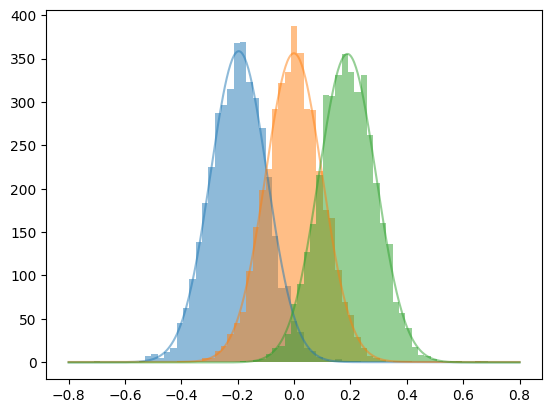

In [7]:
timestamps_CFD_dec0_DATA_00 = Calculate_CFD(data_55[:, :200, 0], fraction = fraction, shift = shift, time_step = time_step)
timestamps_CFD_dec1_DATA_00 = Calculate_CFD(data_55[:, :200, 1], fraction = fraction, shift = shift, time_step = time_step)

timestamps_CFD_dec0_DATA_02 = Calculate_CFD(data_28[:, :200, 0], fraction = fraction, shift = shift, time_step = time_step)
timestamps_CFD_dec1_DATA_02 = Calculate_CFD(data_28[:, :200, 1], fraction = fraction, shift = shift, time_step = time_step)

timestamps_CFD_dec0_DATA_20 = Calculate_CFD(data_82[:, :200, 0], fraction = fraction, shift = shift, time_step = time_step)
timestamps_CFD_dec1_DATA_20 = Calculate_CFD(data_82[:, :200, 1], fraction = fraction, shift = shift, time_step = time_step)

TOF_CFD_V00 = timestamps_CFD_dec0_DATA_00 - timestamps_CFD_dec1_DATA_00
TOF_CFD_V02 = timestamps_CFD_dec0_DATA_02 - timestamps_CFD_dec1_DATA_02
TOF_CFD_V20 = timestamps_CFD_dec0_DATA_20 - timestamps_CFD_dec1_DATA_20

centroid_V00 = calculate_gaussian_center(TOF_CFD_V00[None,:], nbins = nbins, limits = 3) 
plot_gaussian(TOF_CFD_V02, centroid_V00, range = 0.8, label = '-0.2 ns offset', nbins = nbins)
plot_gaussian(TOF_CFD_V00, centroid_V00, range = 0.8, label = ' 0.0 ns offset', nbins = nbins)
plot_gaussian(TOF_CFD_V20, centroid_V00, range = 0.8, label = ' 0.2 ns offset', nbins = nbins)

params_V02, errors_V02 = get_gaussian_params(TOF_CFD_V02, centroid_V00, range = 0.8, nbins = nbins)
params_V00, errors_V00 = get_gaussian_params(TOF_CFD_V00, centroid_V00, range = 0.8, nbins = nbins)
params_V20, errors_V20 = get_gaussian_params(TOF_CFD_V20, centroid_V00, range = 0.8, nbins = nbins)

print("V20: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V20[2], errors_V20[2], params_V20[3], errors_V20[3]))
print("V00: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V00[2], errors_V00[2], params_V00[3], errors_V00[3]))
print("V02: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V02[2], errors_V02[2], params_V02[3], errors_V02[3]))

In [8]:
# -------------------------------------------------------------------------
#--------------------------- BOOTSTRAPING ---------------------------------
# -------------------------------------------------------------------------

resolution_list = []
bias_list = []
MAE_list = []
centroid_00 = []
centroid_02 = []
centroid_20 = []

size_V00 = int(TOF_CFD_V00.shape[0]/10)
size_V02 = int(TOF_CFD_V02.shape[0]/10)
size_V20 = int(TOF_CFD_V20.shape[0]/10)

for i in range(10):
    centroid_V00 = calculate_gaussian_center(TOF_CFD_V00[None, i*size_V00 : (i+1)*size_V00], nbins = nbins, limits = 3) 
    params_V02, errors_V02 = get_gaussian_params(TOF_CFD_V02[i*size_V02 : (i+1)*size_V02], centroid_V00, range = 0.8, nbins = nbins)
    params_V00, errors_V00 = get_gaussian_params(TOF_CFD_V00[i*size_V00 : (i+1)*size_V00], centroid_V00, range = 0.8, nbins = nbins)
    params_V20, errors_V20 = get_gaussian_params(TOF_CFD_V20[i*size_V20 : (i+1)*size_V20], centroid_V00, range = 0.8, nbins = nbins)
    
    
    resolution = np.mean((params_V20[3], params_V00[3], params_V02[3]))
    resolution_list.append(resolution)
    
    centroids = np.array([params_V20[2], params_V00[2], params_V02[2]])
    bias = np.mean(abs(centroids - positions))
    bias_list.append(bias)

    error_V02 = abs((TOF_CFD_V02 - centroid_V00[:, np.newaxis] - positions[2]))
    error_V00 = abs((TOF_CFD_V00 - centroid_V00[:, np.newaxis] - positions[1]))
    error_V20 = abs((TOF_CFD_V20 - centroid_V00[:, np.newaxis] - positions[0]))

    Error = np.concatenate((error_V02, error_V00, error_V20), axis = 1)   
    MAE_list.append(np.mean(Error)) 

    centroid_00.append(params_V00[2])
    centroid_02.append(params_V02[2])
    centroid_20.append(params_V20[2])


print('Mean CTR: ', np.mean(np.array(resolution_list))*1000)
print('Std CTR: ', np.std(np.array(resolution_list))*1000)
print('Mean bias: ', np.mean(np.array(bias_list))*1000)
print('Std bias: ', np.std(np.array(bias_list))*1000)
print('Mean MAE: ', np.mean(np.array(MAE_list))*1000)
print('Std MAE: ', np.std(np.array(MAE_list))*1000)

print('Mean centroid 00: ', np.mean(np.array(centroid_00))*1000)
print('Std centroid 00: ', np.std(np.array(centroid_00))*1000)
print('Mean centroid 02: ', np.mean(np.array(centroid_02))*1000)
print('Std centroid 02: ', np.std(np.array(centroid_02))*1000)
print('Mean centroid 20: ', np.mean(np.array(centroid_20))*1000)
print('Std centroid 20: ', np.std(np.array(centroid_20))*1000)

Mean CTR:  235.9011589591896
Std CTR:  8.943133766544925
Mean bias:  6.004139853839278
Std bias:  2.0941544698705377
Mean MAE:  82.51702350871933
Std MAE:  0.1625360431079156
Mean centroid 00:  -0.9250491983722974
Std centroid 00:  1.4825486492392201
Mean centroid 02:  -196.91697702694964
Std centroid 02:  4.1563531064808075
Mean centroid 20:  188.92893007131178
Std centroid 20:  8.800954660039222


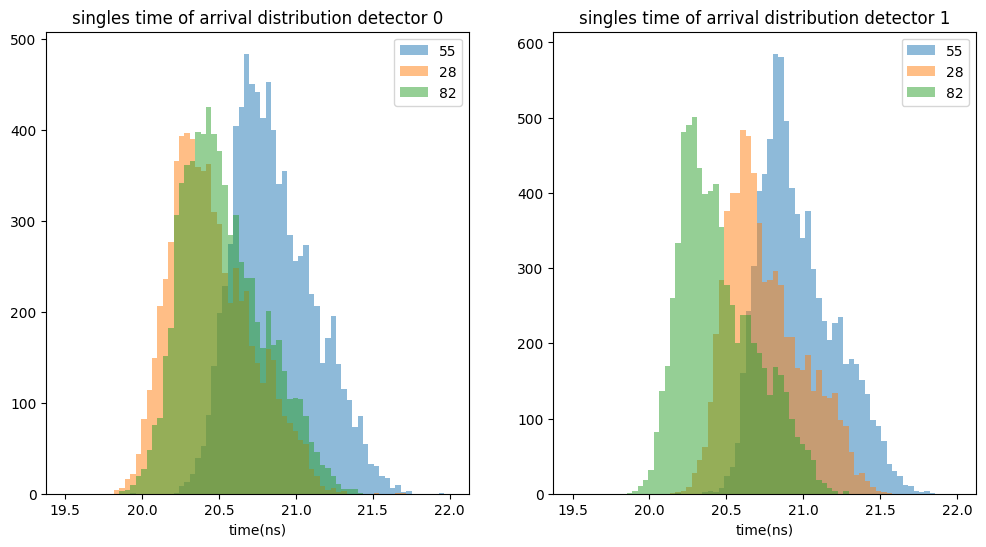

In [9]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.hist(timestamps_CFD_dec0_DATA_00, bins = nbins, range = [19.5, 22], alpha = 0.5, label = '55');
plt.hist(timestamps_CFD_dec0_DATA_02, bins = nbins, range = [19.5, 22], alpha = 0.5, label = '28');
plt.hist(timestamps_CFD_dec0_DATA_20, bins = nbins, range = [19.5, 22], alpha = 0.5, label = '82');
plt.title('singles time of arrival distribution detector 0')
plt.xlabel('time(ns)')
plt.legend()

plt.subplot(122)
plt.hist(timestamps_CFD_dec1_DATA_00, bins = nbins,  range = [19.5, 22], alpha = 0.5, label = '55');
plt.hist(timestamps_CFD_dec1_DATA_02, bins = nbins,  range = [19.5, 22], alpha = 0.5, label = '28');
plt.hist(timestamps_CFD_dec1_DATA_20, bins = nbins,  range = [19.5, 22], alpha = 0.5, label = '82');
plt.title('singles time of arrival distribution detector 1')
plt.xlabel('time(ns)')
plt.legend()

# **RELATIVE LEADING EDGE** 

In [38]:
timestamps_RLED_dec0_DATA_00_list = []
timestamps_RLED_dec0_DATA_02_list = []
timestamps_RLED_dec0_DATA_20_list = []

timestamps_RLED_dec1_DATA_00_list = []
timestamps_RLED_dec1_DATA_02_list = []
timestamps_RLED_dec1_DATA_20_list = []


for i in range(data_55.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(data_55[i,:,0], time_step, threshold = threshold)
  timestamp_dec1 = calculate_slope_y_intercept(data_55[i,:,1], time_step, threshold = threshold)
  timestamps_RLED_dec0_DATA_00_list.append(timestamp_dec0)
  timestamps_RLED_dec1_DATA_00_list.append(timestamp_dec1)

for i in range(data_28.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(data_28[i,:,0], time_step, threshold = threshold)
  timestamp_dec1 = calculate_slope_y_intercept(data_28[i,:,1], time_step, threshold = threshold)
  timestamps_RLED_dec0_DATA_02_list.append(timestamp_dec0)
  timestamps_RLED_dec1_DATA_02_list.append(timestamp_dec1)

for i in range(data_82.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(data_82[i,:,0], time_step, threshold = threshold)
  timestamp_dec1 = calculate_slope_y_intercept(data_82[i,:,1], time_step, threshold = threshold)
  timestamps_RLED_dec0_DATA_20_list.append(timestamp_dec0)
  timestamps_RLED_dec1_DATA_20_list.append(timestamp_dec1)


timestamps_RLED_dec0_DATA_00 = np.array(timestamps_RLED_dec0_DATA_00_list)
timestamps_RLED_dec0_DATA_02 = np.array(timestamps_RLED_dec0_DATA_02_list)
timestamps_RLED_dec0_DATA_20 = np.array(timestamps_RLED_dec0_DATA_20_list)

timestamps_RLED_dec1_DATA_00 = np.array(timestamps_RLED_dec1_DATA_00_list)
timestamps_RLED_dec1_DATA_02 = np.array(timestamps_RLED_dec1_DATA_02_list)
timestamps_RLED_dec1_DATA_20 = np.array(timestamps_RLED_dec1_DATA_20_list)

In [39]:
TOF_RLED_V00 = timestamps_RLED_dec0_DATA_00 - timestamps_RLED_dec1_DATA_00
TOF_RLED_V02 = timestamps_RLED_dec0_DATA_02 - timestamps_RLED_dec1_DATA_02
TOF_RLED_V20 = timestamps_RLED_dec0_DATA_20 - timestamps_RLED_dec1_DATA_20

V20: CENTROID(ns) = 0.1921 +/- 0.00075  FWHM(ns) = 0.2393 +/- 0.00082
V00: CENTROID(ns) = -0.0004 +/- 0.00061  FWHM(ns) = 0.2385 +/- 0.00066
V02: CENTROID(ns) = -0.1918 +/- 0.00085  FWHM(ns) = 0.2369 +/- 0.00092



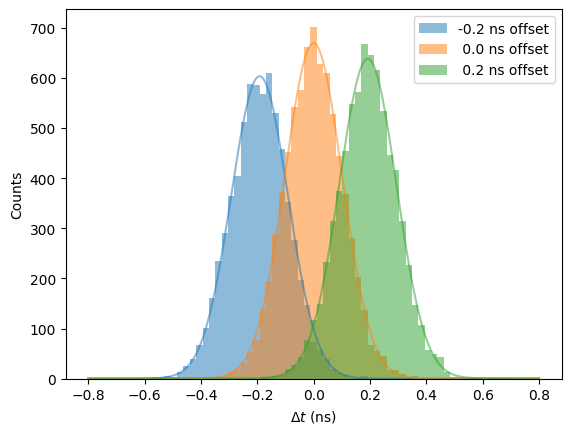

In [40]:
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
centroid_V00 = calculate_gaussian_center(TOF_RLED_V00[None,:], nbins = nbins, limits = 3) 

plot_gaussian(TOF_RLED_V02, centroid_V00, range = 0.8, label = '-0.2 ns offset', nbins = nbins)
plot_gaussian(TOF_RLED_V00, centroid_V00, range = 0.8, label = ' 0.0 ns offset', nbins = nbins)
plot_gaussian(TOF_RLED_V20, centroid_V00, range = 0.8, label = ' 0.2 ns offset', nbins = nbins)

params_V02, errors_V02 = get_gaussian_params(TOF_RLED_V02, centroid_V00, range = 0.8, nbins = nbins)
params_V00, errors_V00 = get_gaussian_params(TOF_RLED_V00, centroid_V00, range = 0.8, nbins = nbins)
params_V20, errors_V20 = get_gaussian_params(TOF_RLED_V20, centroid_V00, range = 0.8, nbins = nbins)

print("V20: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V20[2], errors_V20[2], params_V20[3], errors_V20[3]))
print("V00: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V00[2], errors_V00[2], params_V00[3], errors_V00[3]))
print("V02: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V02[2], errors_V02[2], params_V02[3], errors_V02[3]))

print('')
plt.legend()
plt.xlabel('$\Delta t$ (ns)')
plt.ylabel('Counts')
plt.show()

In [64]:
def continuous_delay2(vector, time_step = 0.2, delay_time = 1, channel_to_fix = 0, channel_to_move = 0):
    
    res = delay_time % time_step  # Fractional part of the delay
    idel = int(delay_time / time_step) 
    
    new_vector = np.zeros_like(vector)
    if delay_time >= 0:
        for i in range(vector.shape[0]):
            for j in range(vector.shape[1] - 1, 0, -1):
                    slope = (vector[i, j, channel_to_move] - vector[i, j - 1, channel_to_move]) / time_step
                    new_vector[i, j, channel_to_move] =  vector[i, j, channel_to_move] - slope * res 
            new_vector[i,0, channel_to_move] = vector[i,0, channel_to_move]
            new_vector[i,:,channel_to_move] = np.roll(new_vector[i,:,channel_to_move], idel)
            new_vector[i,:idel,channel_to_move] = 0
        new_vector[:,:,channel_to_fix] = vector[:,:,channel_to_fix]


    if delay_time < 0:
        for i in range(vector.shape[0]):
            for j in range(vector.shape[1] - 1):
                    slope = (vector[i, j + 1, channel_to_move] - vector[i, j, channel_to_move]) / time_step
                    new_vector[i, j, channel_to_move] =  vector[i, j, channel_to_move] + slope * res 
            new_vector[i,-1, channel_to_move] = vector[i,-1, channel_to_move]
            if idel <= -1:
                new_vector[i,:,channel_to_move] = np.roll(new_vector[i,:,channel_to_move], idel)
                new_vector[i,idel:,channel_to_move] = vector[i, idel:, channel_to_move]
            else:
                pass
        new_vector[:,:,channel_to_fix] = vector[:,:,channel_to_fix]
    return new_vector


In [133]:
a = continuous_delay2(data_55, time_step = 0.2, delay_time = 0.127, channel_to_fix = 1, channel_to_move = 0)

In [134]:
timestamps_RLED_dec0_DATA_00_list = []
timestamps_RLED_dec1_DATA_00_list = []


for i in range(a.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(a[i,:,0], time_step, threshold = threshold)
  timestamp_dec1 = calculate_slope_y_intercept(a[i,:,1], time_step, threshold = threshold)
  timestamps_RLED_dec0_DATA_00_list.append(timestamp_dec0)
  timestamps_RLED_dec1_DATA_00_list.append(timestamp_dec1)

timestamps_RLED_dec0_DATA_00 = np.array(timestamps_RLED_dec0_DATA_00_list)
timestamps_RLED_dec1_DATA_00 = np.array(timestamps_RLED_dec1_DATA_00_list)


In [135]:
TOF_RLED_V00 = timestamps_RLED_dec0_DATA_00 - timestamps_RLED_dec1_DATA_00

V20: CENTROID(ns) = -0.0007 +/- 0.00043  FWHM(ns) = 0.2375 +/- 0.00046



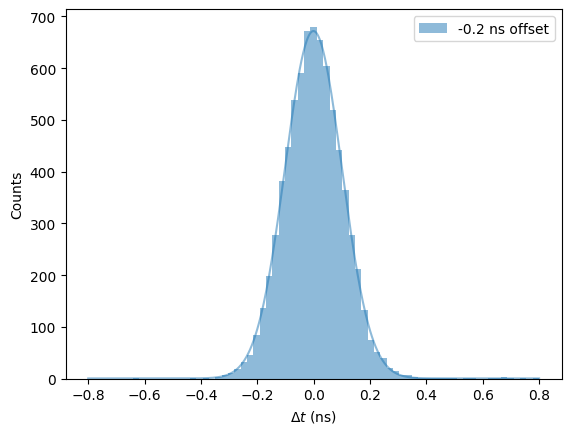

In [137]:
plot_gaussian(TOF_RLED_V00, 0, range = 0.8, label = '-0.2 ns offset', nbins = nbins)

params_V02, errors_V02 = get_gaussian_params(TOF_RLED_V00, 0, range = 0.8, nbins = nbins)

print("V20: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V02[2], errors_V02[2], params_V02[3], errors_V02[3]))

print('')
plt.legend()
plt.xlabel('$\Delta t$ (ns)')
plt.ylabel('Counts')
plt.show()

In [13]:
# -------------------------------------------------------------------------
#--------------------------- BOOTSTRAPING ---------------------------------
# -------------------------------------------------------------------------

resolution_list = []
bias_list = []
MAE_list = []
centroid_00 = []
centroid_02 = []
centroid_20 = []

size_V00 = int(TOF_RLED_V00.shape[0]/10)
size_V02 = int(TOF_RLED_V02.shape[0]/10)
size_V20 = int(TOF_RLED_V20.shape[0]/10)

for i in range(10):
    centroid_V00 = calculate_gaussian_center(TOF_RLED_V00[None, i*size_V00 : (i+1)*size_V00], nbins = nbins, limits = 3) 
    params_V02, errors_V02 = get_gaussian_params(TOF_RLED_V02[i*size_V02 : (i+1)*size_V02], centroid_V00, range = 0.8, nbins = nbins)
    params_V00, errors_V00 = get_gaussian_params(TOF_RLED_V00[i*size_V00 : (i+1)*size_V00], centroid_V00, range = 0.8, nbins = nbins)
    params_V20, errors_V20 = get_gaussian_params(TOF_RLED_V20[i*size_V20 : (i+1)*size_V20], centroid_V00, range = 0.8, nbins = nbins)
    
    
    resolution = np.mean((params_V20[3], params_V00[3], params_V02[3]))
    resolution_list.append(resolution)
    
    centroids = np.array([params_V20[2], params_V00[2], params_V02[2]])
    bias = np.mean(abs(centroids - positions))
    bias_list.append(bias)

    error_V02 = abs((TOF_RLED_V02 - centroid_V00[:, np.newaxis] - positions[2]))
    error_V00 = abs((TOF_RLED_V00 - centroid_V00[:, np.newaxis] - positions[1]))
    error_V20 = abs((TOF_RLED_V20 - centroid_V00[:, np.newaxis] - positions[0]))

    Error = np.concatenate((error_V02, error_V00, error_V20), axis = 1)   
    MAE_list.append(np.mean(Error)) 

    centroid_00.append(params_V00[2])
    centroid_02.append(params_V02[2])
    centroid_20.append(params_V20[2])


print('Mean CTR: ', np.mean(np.array(resolution_list))*1000)
print('Std CTR: ', np.std(np.array(resolution_list))*1000)
print('Mean bias: ', np.mean(np.array(bias_list))*1000)
print('Std bias: ', np.std(np.array(bias_list))*1000)
print('Mean MAE: ', np.mean(np.array(MAE_list))*1000)
print('Std MAE: ', np.std(np.array(MAE_list))*1000)

print('Mean centroid 00: ', np.mean(np.array(centroid_00))*1000)
print('Std centroid 00: ', np.std(np.array(centroid_00))*1000)
print('Mean centroid 02: ', np.mean(np.array(centroid_02))*1000)
print('Std centroid 02: ', np.std(np.array(centroid_02))*1000)
print('Mean centroid 20: ', np.mean(np.array(centroid_20))*1000)
print('Std centroid 20: ', np.std(np.array(centroid_20))*1000)


Mean CTR:  237.3680443447729
Std CTR:  6.552951398457397
Mean bias:  6.126158422362306
Std bias:  2.044936706476739
Mean MAE:  241.5083504286764
Std MAE:  0.29062835518950836
Mean centroid 00:  -0.34290523001424555
Std centroid 00:  1.4082580639654838
Mean centroid 02:  -191.83607893476747
Std centroid 02:  8.803476297768409
Mean centroid 20:  191.89437516413264
Std centroid 20:  6.237802158532385
